<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Decision Trees
              
</p>
</div>

Data Science Cohort Live NYC July 2022
<p>Phase 3: Topic 27</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

#### Decision Trees at a High Level

Decision trees can be viewed as a series of forks in the road.

<a title="Jonathan Billinger / Fork in the road" href="https://commons.wikimedia.org/wiki/File:Fork_in_the_road_-_geograph.org.uk_-_1355424.jpg"><img width="512" alt="Fork in the road - geograph.org.uk - 1355424" src="https://upload.wikimedia.org/wikipedia/commons/7/71/Fork_in_the_road_-_geograph.org.uk_-_1355424.jpg"></a>

Every time we make a decision, we split up, or *partition*, the data based on the features.

- optimizing for a metric that aids us in separating feature space according to class assignment.

#### Simple Example of a Decision Tree

Let's say we have this set of data:

Work Status |  Age  | Favorite Website
------------|-------|-------------------------
 Student    | Young | A
 Working    | Young | B
 Working    | Old   | C
 Working    | Young | B
 Student    | Young | A
 Student    | Young | A



This can help us answer the question:

Based on age and work status, what website will user likely choose as their favorite?

#### Picturing Decisions as a Tree

A reasonable decision tree that might represent the data we have:


Work Status |  Age  | Favorite Website
------------|-------|-------------------------
 Student    | Young | A
 Working    | Young | B
 Working    | Old   | C
 Working    | Young | B
 Student    | Young | A
 Student    | Young | A
 Student    | Old   | C


![](images/simple_decision_tree.png)

Our first split was on Age: 
- chose based on observation: old people choose website C
- leaf has only members belong to class C 

**This defines region of feature space where we predict class C**

![](images/simple_decision_tree.png)

Our first split was on Age: 
- inside feature space partition where Age = Young
    - Notice that we have a mixed bag here
    
Work Status |  Age  | Favorite Website
------------|-------|-------------------------
 Student    | Young | A
 Working    | Young | B
 Working    | Old   | C
 Working    | Young | B
 Student    | Young | A
 Student    | Young | A
 Student    | Old   | C


Use other feature (work status):
- will it help us in determining between class A and B?

A further split based on work status inside current partition: differentiates between class A and class B

<center><img src = "images/simple_decision_tree.png" width = 400></center>

#### Overview of Algorithm's Steps

1. Split data features $X$ and target $y$

One big advantage of tree-based algorithms: 
- $X$ does not **need** to be scaled and often no transformations required
- categorical feature can be handled easily

2. Make a *decision* (a split) based on some notion that given split aids in separating different classes in feature space.
  - *Data split into partitions via *branches*



<center><img src = "images/simple_decision_tree.png" width = 400></center>

3. Continue on with each partition: 
    - do more splits for each partition using another feature
    - if splits aid in class differentiation within each separate partition



<center><img src = "images/simple_decision_tree.png" width = 400></center>

Note: **Splitting is a recursive process**

<center><img src = "images/recursion.png" width = 400></center>

Second level splits:
- only conidering class differentiation criterion within each partition locally

This sort of algorithm locally optimizing on specific criterion:
- known as **greedy algorithm**

**Greedy algorithms that work in recursive structure: often blindingly fast**

- Yes, decision trees are really fast algorithms

4. Keep at this game: until a **stopping condition** is hit
    - each partition(leaf) has only one class in it
    - OR hit a pre-defined maximum tree depth


<center><img src = "images/decisiontreepure.gif" width = 700></center>

5. To make predictions, flow data points $X$ down the tree: 
- through the decision nodes to predictions at the leaves

<center><img src = "images/simple_decision_tree.png" width = 400></center>
<center>Tree is trained model.</center>

We have new observation of a person: X = (Young, Working)

A very nice demo on decision trees using some real data:

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

#### Entropy/Gini Impurity and the Notion of Information Gain
- Metrics used to decided where a split is made.
- measures notions of class purity/heterogeneity in a given partition

Ideal goal: partitions are fully pure/homogenous with respect to class labels

<center><img src = "images/decisiontreepure.gif" width = 700></center>

#### Entropy
- A measure of class heterogeity within a partition

The entropy within a partition is given by:

$$ E = -\sum_{i=1}^k p_i\log_k(p_i)$$

- $k$ is number of classes
- $p_i$ is relative frequency of $i$th class


Take simple example of binary classification:

$$ E = -\sum_{i=1}^2 p_i\log_2(p_i) = \\ -p_1 \log_2p_1 - (1 - p_1)\log_2(1-p_1)$$

<center><img src = "images/entropy_levels.png" width = 700></center>
<center>Left to right: low to high entropy, increasing heterogeneity</center>

**Calculating the entropy for equal class support in partition**
- high heterogeneity

<center><img src = "images/entropy_equalpart.png" width = 200></center>
<center>Maximum heterogeneity</center>

Since two groups and equal split between classes:

- $ p_i = \frac{1}{2}$ for  $i = 1,2$

Calculating the entropy: $ E = -\sum_{i=1}^2 p_i\log_2(p_i) = -p_1 \log_2p_1 - (1 - p_1)\log_2(1-p_1)$

$$ E =  -2*\frac{1}{2}\log_2(\frac{1}{2}) $$
$$E = -\log_2(\frac{1}{2})= 1 $$

**Calculating the entropy for partition with only one class**
- homogenous

$ E = -p_1 \log_2p_1 - (1 - p_1)\log_2p_1$

where $p_1 = 1$

$$ E = -\log_2(1) = 0$$

Looking at the ranges between:
- entropy traces out a curve

In [20]:
epsilon = 1e-7 #prevent explosion from log
entropy = lambda p: -(p*np.log2(p + epsilon) \
                      + (1-p)*np.log2(1-p + epsilon))

p_range = np.linspace(0,1,50)
entropy_array = entropy(p_range)

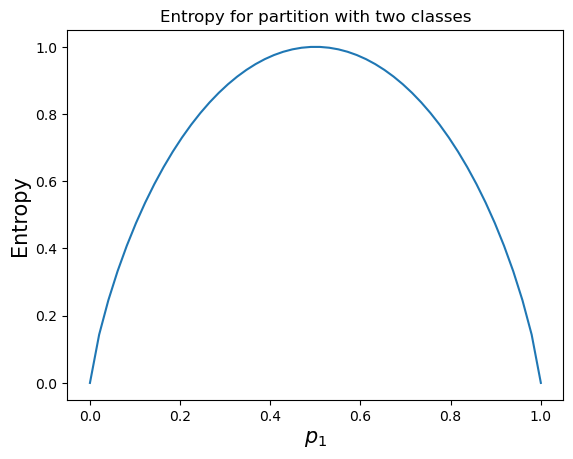

In [21]:
plt.plot(p_range, entropy_array)
plt.ylabel('Entropy', size = 15)
plt.xlabel(r'$p_1$', size = 15)
plt.title('Entropy for partition with two classes')
plt.show()

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

For a given parent partition: want a split where
- weighted average of entropy over children partition lower than parent partition entropy

i.e., children are statistically speaking more pure than parent

<center><img src = "images/partinfo.png" width = 500></center>
<center>Is the weighted sum of children entropy lower than parent?</center>

In [26]:
# calculate it

p1_parent = 7/13

parent_entropy = - p1_parent*np.log2(p1_parent) - (1 - p1_parent)*np.log2(1-p1_parent)


p1_child = 5/6
child1_entropy = - p1_child*np.log2(p1_child) - (1 - p1_child)*np.log2(1-p1_child)
p2_child = 2/7
child2_entropy =  - p2_child*np.log2(p2_child) - (1 - p2_child)*np.log2(1-p2_child)

final_entropy = (6/13)*child1_entropy + (7/13)*child2_entropy

print(final_entropy)
print(parent_entropy)

0.7647675776812725
0.9957274520849255


**Information Gain**

**information gain** = **children entropy** - **parent's entropy** 

What we want:

A split on a feature $X_1$ that results in good information gain:

<center><img src = "images/x1splitfeature.png" width = 500></center>
<center>Tuning $X_1$ for split: scanning feature space</center>

<center><img src = "images/x1feature_infogain.png" width = 500></center>
<center>Tuning $X_1$ for split: best information gain</center>


- choose value of $X_1$ to split on that has the lowest **children entropy** - **parent's entropy** (best information gain)

Decision trees optimization in partition:
- computes information gain for many values of $X_1$
- finds $X_1$ at minimum value of information gain
- splits there.

#### Gini Impurity

An alternative metric to entropy.

Gini Impurity is defined as:

$$ G = 1 - \sum_{i=1}^k p_i^2 $$

- Gini impurity heavily penalizes heterogeneity (more strongly than entropy)

**For binary problem:**
- $0 \leq G \leq 0.5$
- Closer to 0.5, the more heterogenous the partition.

Calculation of information gain same: just with Gini impurity instead of entropy

$$G_{children} - G_{parent}$$

**Putting it all together**

1. Choose feature $X$ and tune to get optimal split for information gain
2. Make split and partition.
3. In each new partition, choose a different $X'$.
4. Ttune to get optimal split for information gain.
5. Make split and partition.
6. Rinse, repeat.

**Question**: Are we guaranteed, proceeding in this way, to reach pure groups, no matter what our data looks like?

Decision trees very prone to overfitting.
- will continue to split until all leafs are pure
- can get way too complex (every point has its own partition)

Will need a way to limit tree complexity/depth to aid in generalization:
- avoid overfitting

**Strategies/decision tree hyperparameters that aid with this. Discuss these while tuning**

#### Implement a decision tree classifier in Scikit-learn

#### Setting up Data

In [5]:
iris_df = sns.load_dataset('iris')[['petal_width', 'sepal_length', 'species']]
iris_df.head()

,petal_width,sepal_length,species
0,0.2,5.1,setosa
1,0.2,4.9,setosa
2,0.2,4.7,setosa
3,0.2,4.6,setosa
4,0.2,5.0,setosa


In [6]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   petal_width   150 non-null    float64
 1   sepal_length  150 non-null    float64
 2   species       150 non-null    object 
dtypes: float64(2), object(1)
memory usage: 3.6+ KB


In [7]:
X = iris_df.drop(columns = ['species'])
labenc = LabelEncoder()
y = labenc.fit_transform(iris_df.species)

C:\Users\Praveen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Praveen\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


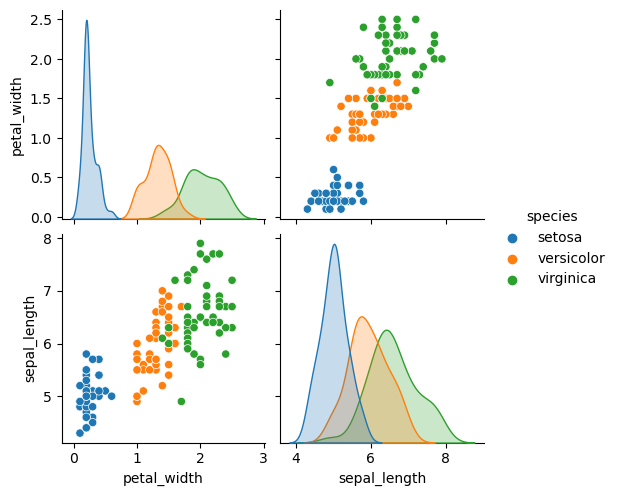

In [8]:
sns.pairplot(iris_df, hue = 'species')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

X_train.shape, X_test.shape

((105, 2), (45, 2))

#### Training the model out of the box

In [10]:
tree_clf = DecisionTreeClassifier(criterion = 'gini', random_state=42)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

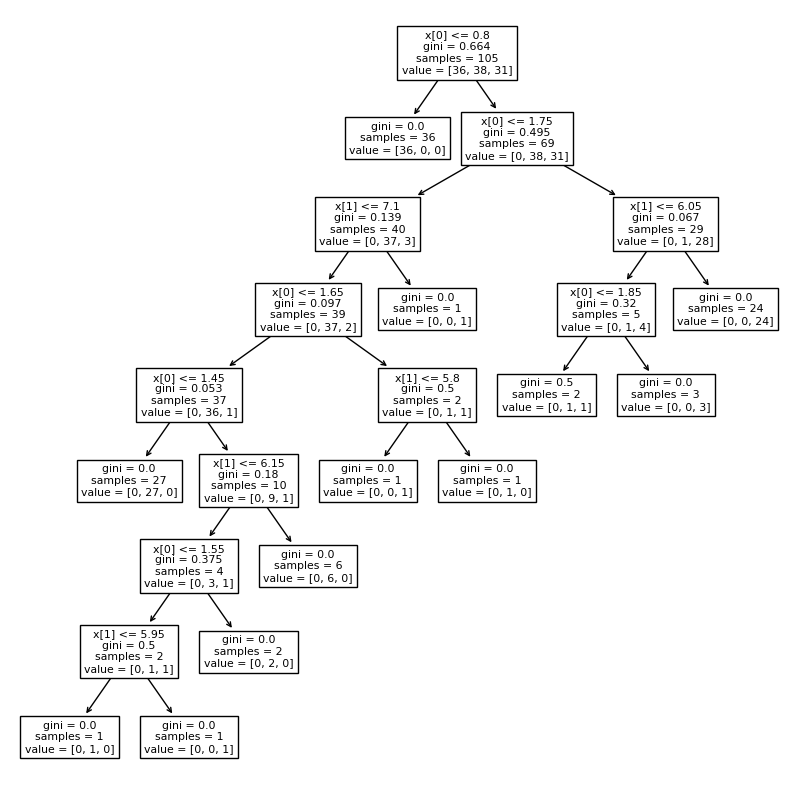

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_clf, ax=ax);

A complex model:
- depth = 9
- alarm bells should be going off

Train accuracy is pretty high

In [12]:
tree_clf.score(X_train, y_train)

0.9904761904761905

#### Test set evaluation

In [13]:
y_pred = tree_clf.predict(X_test)
y_pred

array([1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 2, 0,
       0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2,
       2])

In [14]:
acc = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {0}".format(acc))

Accuracy: 91.11111111111111


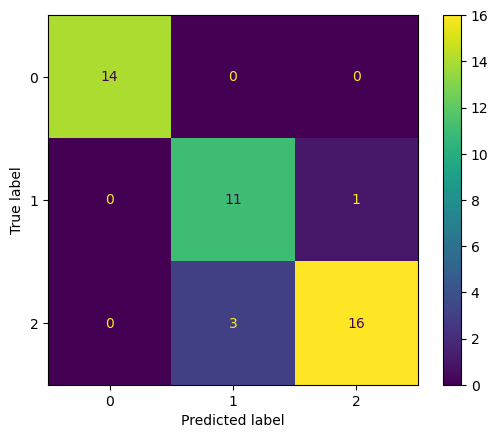

In [15]:
ConfusionMatrixDisplay.from_estimator(tree_clf, X_test, y_test);

Lower test set accuracy. Sign of variance issues. But how bad is it?

- Visualizing decision boundary may help.

C:\Users\Praveen\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


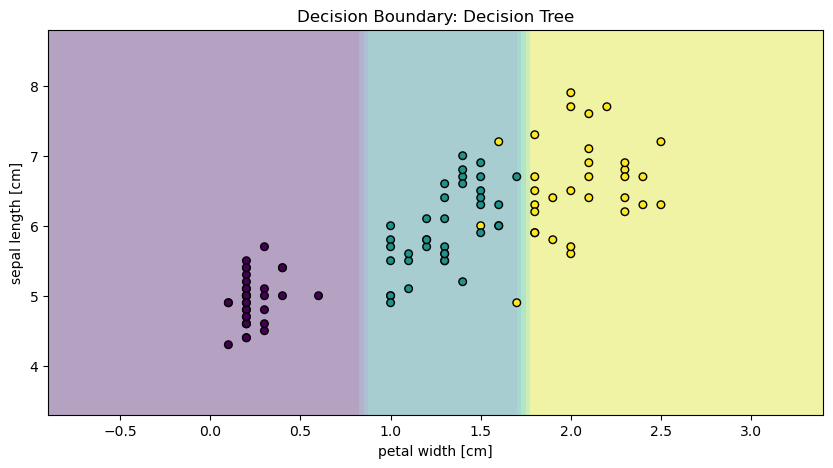

In [28]:
X_2D = X_train.values

x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1

xx_n, yy_n = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, ax = plt.subplots(figsize = (10,5))

Z = tree_clf.predict(np.c_[xx_n.ravel(), yy_n.ravel()])
Z = Z.reshape(xx_n.shape)
ax.contourf(xx_n, yy_n, Z, alpha=0.4)
ax.scatter(X_2D[:, 0], X_2D[:, 1], c = y_train, s=30, edgecolor="k")
ax.set_xlabel('petal width [cm]')
ax.set_ylabel('sepal length [cm]')
ax.set_title('Decision Boundary: Decision Tree')

plt.show()

Boundary unstable to single points:
- strange fluctuations in decision boundary.

Tree has split to high depth:
- to get as pure as possible.

#### Bias-Variance with Decision Trees

- CART algorithm repeatedly partition data into smaller and smaller subsets 
- until final subsets homogeneous in target. 
- often means final partitions (leaves of the tree): few data points. 

**Low-bias, high variance models.**

Need parameters that have a regularizing effect:
- stopping criterion

Put in some conditions to prevent tree growing to overfit train set.

#### Commonly tuned hyperparameters

**Max depth**
-  DecisionTreeClassifier(max_depth = __)
- Sets maximum depth tree can grow. Prevents overfitting.

<center><img src = "images/treedepth.png"></center>

Stops tree from growing too big:
- in actuality, grows tree all the way and uses rule-based algorithm to prune back to specified depth
- Good values of max_depth depend on data complexity (can range from 2 to 12...sometimes bigger)

**Minimum number of samples in parent for allowing a split**
-  DecisionTreeClassifier(min_samples_split = __)

<center><img src = "images/minsampleplit.png"></center>

**Minimum samples in leaf allowed in children** min_sample_leaf

- constrains number of samples in children when optimizing information gain on leafs

<center><img src = "images/minsampleleaf.png"></center>

Training: 0.9619047619047619
Testing: 0.9555555555555556


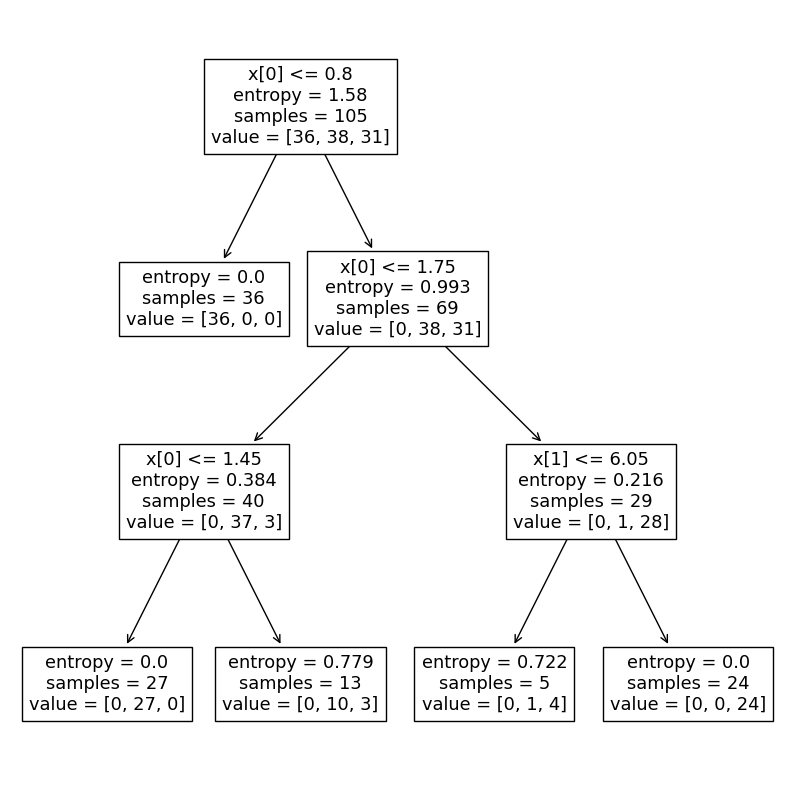

In [27]:

# Stop it from running too long
tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3,  random_state=42)
tree_clf.fit(X_train, y_train)

# Accuracy on training data & test data
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))


f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_clf, ax=ax);

#### Feature Importances

The fitted tree has an attribute called `ct.feature_importances_`:

- Importance of feature: impurity decrease averaged over nodes splitting on given feature. (roughly) 

i.e., how useful is feature in model for aiding in class differentiation?

In [30]:
for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)

0.982477051645365 petal_width
0.017522948354635005 sepal_length


#### Pros

- Easy to interpret and visualize model structure
- Can easily capture non-linear patterns in features
- Require little data preprocessing from the user (no need to normalize data)
- Make no assumptions about distribution because its non-parametric

#### Cons

- Sensitive to noisy data (overfit)
- Trouble with imbalanced datasets
- Predictive accuracy usually not as good as other approaches.

But aggregating many decision trees together: 
- the predictive performance can be improved substantially.
- still keep a high degree of speed